In [ ]:
# Importing Dependencies
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Mounting Google Drive.  Don't have to run again if it has already been mounted.
#drive.mount('/content/drive')

# Providing the Paths to the Training, Validation, and Testing data
training_path = '/content/drive/MyDrive/P4_MicroPystics/Resources/1_Training'
validation_path = '/content/drive/MyDrive/P4_MicroPystics/Resources/2_Validation'
testing_path = '/content/drive/MyDrive/P4_MicroPystics/Resources/3_Testing'

# Resizing the jpgs to 128x128 to reduce processing needs and to provide uniform images
def resize_images(image):
    resized_image = resize(image.squeeze(), (128, 128))
    return np.expand_dims(resized_image, axis=-1)

# Loading the JPGs as B&W to save memory
def rgb_to_gray(image):
    return rgb2gray(image)

# All jpgs should be the same size (128,128), however, rescaling in anticipation of Neural Networking modeling later in the process.
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True
)

# Defining Training and Validation sets
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=577,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=104,
    class_mode='binary',
    subset='validation'
)

Found 463 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


In [ ]:
# Check the shape of the output from resize_images
sample_batch = next(train_generator)
sample_image = sample_batch[0][0]  # Taking the first image from the batch
print("Shape after resize_images:", sample_image.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Shape after resize_images: (128, 128, 3)


In [ ]:
# Building the Image Classification Model, using Convolutional Neural Network, via MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the convolutional base
base_model.trainable = False

# Moddeling with classification head on top of MobileNetV2
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Training the Model
epochs = 30

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

Epoch 1/30
1/1 [==============================] - 20s 20s/step - loss: 0.0649 - accuracy: 0.9806 - val_loss: 0.2175 - val_accuracy: 0.8860
Epoch 2/30
1/1 [==============================] - 16s 16s/step - loss: 0.0514 - accuracy: 0.9870 - val_loss: 0.1628 - val_accuracy: 0.9561
Epoch 3/30
1/1 [==============================] - 16s 16s/step - loss: 0.0422 - accuracy: 0.9957 - val_loss: 0.1250 - val_accuracy: 0.9649
Epoch 4/30
1/1 [==============================] - 16s 16s/step - loss: 0.0385 - accuracy: 0.9978 - val_loss: 0.1042 - val_accuracy: 0.9737
Epoch 5/30
1/1 [==============================] - 16s 16s/step - loss: 0.0369 - accuracy: 0.9978 - val_loss: 0.0951 - val_accuracy: 0.9737
Epoch 6/30
1/1 [==============================] - 16s 16s/step - loss: 0.0339 - accuracy: 0.9978 - val_loss: 0.0944 - val_accuracy: 0.9737
Epoch 7/30
1/1 [==============================] - 16s 16s/step - loss: 0.0295 - accuracy: 0.9978 - val_loss: 0.1006 - val_accuracy: 0.9649
Epoch 8/30
1/1 [===========

In [ ]:
# Evaluating the model on the testing set
testing_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=100,
    class_mode='binary',
    shuffle=False
)

# Generating predictions on the testing set
predictions = model.predict(testing_generator)

# Converting predictions to binary values (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Getting true labels from the generator
true_labels = testing_generator.classes

# Calculating accuracy
accuracy = np.mean(binary_predictions == true_labels)
print(f'Testing Accuracy: {accuracy}')

Found 100 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step
Testing Accuracy: 0.6984


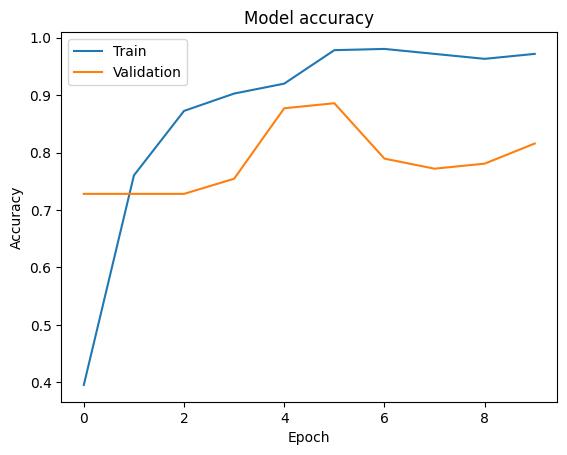

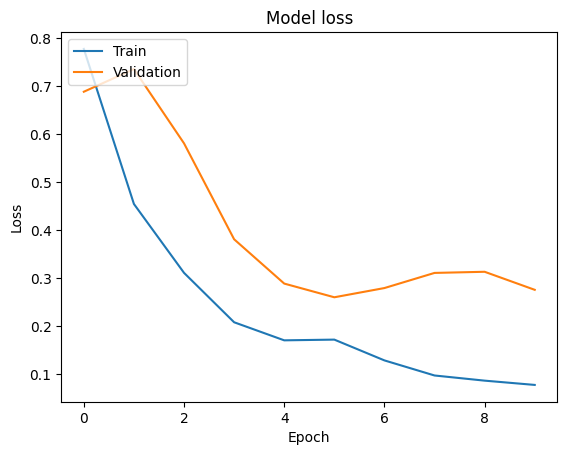

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()